In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve

#read data 
hotel_reviews = pd.read_csv('hotel_reviews_raw_data.csv')

In [2]:
#drop duplicate values
hotel_reviews.drop_duplicates(['text'], inplace=True)
#hotel_reviews.drop(['polarity'], 1, inplace=True)

In [3]:
#encode label
le = LabelEncoder()
label = le.fit_transform(hotel_reviews['deceptive'])

In [4]:
#define X and y
X = np.array(hotel_reviews['text'])
y = np.array(label)

# encoding polarity.
P = le.fit_transform(hotel_reviews['polarity'])
Polarity = np.array(P).reshape(1596,1)
print (Polarity.shape)

(1596, 1)


In [5]:
#turn text into numeric feature vectors
#vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
#reviews = vec.fit_transform(X) #vocabulary created using all data

vec = CountVectorizer(stop_words='english', ngram_range=(1,2)).fit(X)
reviews = vec.transform(X)
print("X_train:\n{}".format(repr(X)))


X_train:
array(['We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n',
       'Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n',
       "This comes a little late as I'm finally catching up on my reviews from the past several months:) A de

In [6]:
feature_names = vec.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 81609
First 20 features:
['00' '00 24' '00 aaa' '00 able' '00 added' '00 bottle' '00 bucks'
 '00 buy' '00 called' '00 compared' '00 complain' '00 day' '00 did'
 '00 disappointed' '00 fare' '00 free' '00 friday' '00 given' '00 great'
 '00 luxury']
Features 20010 to 20030:
['desk curbside' 'desk customers' 'desk dark' 'desk day' 'desk decided'
 'desk delivered' 'desk demanded' 'desk designer' 'desk desk' 'desk did'
 'desk didn' 'desk disorganized' 'desk doorman' 'desk downright'
 'desk efficient' 'desk employee' 'desk employees' 'desk ended'
 'desk experience' 'desk explain']
Every 2000th feature:
['00' 'add room' 'area great' 'backtrack hotel' 'best bathrooms'
 'building street' 'charge wifi' 'clean bed' 'complicated' 'crew did'
 'desk cleverly' 'doesnt' 'encountered modern' 'extra chair'
 'flight sighed' 'generally speaking' 'guess paint' 'historic feel'
 'hour stop' 'intercontinental weekend' 'lamb chops' 'load bearing'
 'maintained luxury' 'minutes end' 'nice let'

In [7]:
Reviews_with_Polarity = np.append(reviews.todense(), Polarity, axis=1)
#print (Reviews_with_Polarity[:,9284])

X_train, X_test, y_train, y_test = train_test_split(
    Reviews_with_Polarity, y, random_state=0, shuffle=True)
#NOTE: to include Polarity replace 'reviews' with 'Reviews_with_Polarity' in the splitting above.

In [8]:
X_train = np.array(X_train)

In [9]:
#train random forest classifier
clf = RandomForestClassifier(bootstrap=True, n_estimators=100, max_depth=None, min_samples_split=5, random_state=7, oob_score=True)
clf.fit(X_train,y_train)


RandomForestClassifier(min_samples_split=5, oob_score=True, random_state=7)

In [10]:
#Get feature names
names = vec.get_feature_names_out()

In [11]:
#print features and importance scores
#print (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), reverse=True))

#create subset of features
sfm = SelectFromModel(clf, threshold=0.00015)

sfm.fit(X_train, y_train)


#X_best_features_train = sfm.transform(X_train)
#X_best_features_test = sfm.transform(X_test)
X_best_features_train = X_train
X_best_features_test = X_test

In [12]:
#prepare algorithms to test
models = []
models.append(('NB', MultinomialNB()))
models.append(('kNN', KNeighborsClassifier(n_neighbors = 10)))
models.append(('LogR', LogisticRegression()))
models.append(('SVC', SVC(C=10, gamma=0.001))) #model is tuned using GridSearch (code in seperate file)
models.append(('DT', tree.DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(bootstrap=True, n_estimators=50, max_depth=None,min_samples_split=5, random_state=7)))
models.append(('AdaB', AdaBoostClassifier()))

In [13]:
#evaluate each algorithm
results = []
names = []
for name, model in models:
    #If not statified, shuffle is vital given data is ordered by labels.
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, X_best_features_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

NB: 0.871366 (0.029839)
kNN: 0.508683 (0.033380)
LogR: 0.857143 (0.041940)
SVC: 0.861331 (0.039695)
DT: 0.685952 (0.040552)
RF: 0.841268 (0.040052)
AdaB: 0.813761 (0.041142)


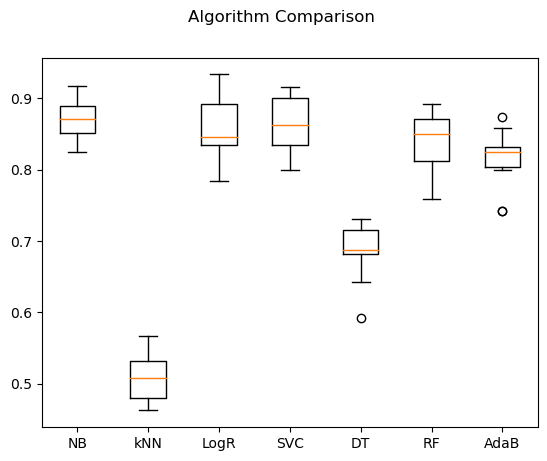

In [15]:
#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()